In [1]:
# import necessary packages/modules

import pandas as pd
import json
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from animate_func import create_gif
from collections import Counter
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import math
import copy
import pickle


In [2]:
# read in paths
with open('SETTINGS.json') as f:
    settings = json.load(f)

In [3]:
for path in settings.values():
    if not os.path.exists(path):
            os.mkdir(path)

In [4]:
settings

{'PROVIDED_RAW_DATA_DIR': './data/raw_data/provided_data/',
 'EXTERNAL_RAW_DATA_DIR': './data/raw_data/external_data/',
 'AGGREGATED_DATA': './data/processed/agg_data/',
 'MODELS': './models/',
 'OUTPUT_GIFS': './output/gifs/',
 'OUTPUT_FIGS': './output/figs/'}

In [5]:
# aggregate all weeks' tracking data into a single tracking dataframe

provided_data_path = settings['PROVIDED_RAW_DATA_DIR']

tracking_list = []

# read in and concat week-specific data
for f_path in glob.glob(f'{provided_data_path}*week*'):
    temp_df = pd.read_csv(f_path)
    tracking_list.append(temp_df)
tracking = pd.concat(tracking_list, axis = 0)



In [6]:
# read in other provided data

plays = pd.read_csv(f'{provided_data_path}plays.csv').reset_index(drop = True)
players = pd.read_csv(f'{provided_data_path}players.csv').reset_index(drop = True)
games = pd.read_csv(f'{provided_data_path}games.csv').reset_index(drop = True)
tackles = pd.read_csv(f'{provided_data_path}tackles.csv').reset_index(drop = True)


In [7]:
# add unique game_play identifiers to provided data

def make_gameplay(gameid, playid):
    return '_'.join([str(gameid), str(playid)])

def add_gameplay_col(df):
    gameplay_vals = df.apply(lambda x: make_gameplay(x['gameId'], x['playId']), axis = 1)
    df.insert(loc = 0, column = 'gameplayId', value = gameplay_vals)
    return df

dfs_with_gameplay = [tracking, tackles, plays]

for df in dfs_with_gameplay:
    df = add_gameplay_col(df)


In [8]:
# save processed dataframes to agg_data subdirectory
tracking.to_csv(f'{settings['AGGREGATED_DATA']}tracking.csv')
tackles.to_csv(f'{settings['AGGREGATED_DATA']}tackles.csv')
plays.to_csv(f'{settings['AGGREGATED_DATA']}plays.csv')

In [9]:
def find_play_rb_dir(gp, tracking_df = tracking, players_df=players):
    '''
    Find the relative direction of the play and which side of the QB the RB is on in shotgun
    '''

    # subset tracking data to certain gameplay
    tracking_play = tracking_df.loc[tracking_df['gameplayId'] == gp].reset_index(drop = True)
    all_qbs = players_df['displayName'].loc[players_df['position'] == 'QB'].values

    # get QB details for given play
    qb_info = tracking_play[['displayName', 'x', 'y']].loc[tracking_play['displayName'].isin(all_qbs)].values

    if len(qb_info) == 0:
        return False # exit with False if there's no QB on the field (discard)
    else:
        qb_name, qb_x, qb_y = qb_info[0]


    # identify players lined up as RB by being within 5 yards width-wise and 1.5 yards length-wise of QB
    all_rb_vals = tracking_play[['x', 'y', 'nflId']].loc[
        (np.abs(tracking_play['x']-qb_x) < 1.5) & 
        (np.abs(tracking_play['y']-qb_y) < 5) &
        (tracking_play['displayName'] != qb_name)].reset_index(drop = True)
    


    if all_rb_vals['nflId'].nunique() != 1: # if there is zero or more than one RB, discard
        return False

    else:
        rb_x, rb_y = all_rb_vals[['x', 'y']].iloc[0]

    play_dir = tracking_play['playDirection'].values[0]

    # assign which side of QB the RB is on based on play direction and relative y-position values
    if play_dir == 'left':
        if rb_y > qb_y:
            rb_side = 'right'
        else:
            rb_side = 'left'
    
    elif play_dir == 'right':
        if rb_y > qb_y:
            rb_side = 'left'
        else:
            rb_side = 'right'

    return play_dir, rb_side

def classify_defender(ballx, bally, playerx, playery):
    '''
    First pass at classifying defender's position on field without using roster info
    Output not utilized in this workflow
    '''
    if (np.abs(playerx - ballx) < 1.5) & (np.abs(playery - bally) < 9):
        pos = 'line'
    elif (np.abs(playerx - ballx) >= 1.5) & (np.abs(playerx - ballx) < 5) & (np.abs(playery - bally) < 9):
        pos = 'backer'
    else:
        pos = 'secondary'
    return pos


# def get_defender_by_y(sub_df, relative_y, num_players_in = 1, highest_lowest_dlinemen_y = None, ball_pos = None):
def get_defender_by_y(sub_df, relative_y, num_players_in = 1, ball_pos = None):


    '''
    sub_df is a subset of the total defense dataframe (namely, the backers or dlinemen dataframe)
    returns a specific defender according to their relative y-coordinate positioning on the field
    num_players_in refers to how many players in to the line we should count
    in this script, it is always passed in as 1, but this could be varied according to defensive formation for potentially increased resolution
    ball_pos is a collection of [ball_pos_x, ball_pos_y]
    '''

    if ball_pos:
        ball_pos_x, ball_pos_y = ball_pos

    if relative_y == 'lowest': # if we're looking for defender furthest to bottom of field
        try: 
            player = sub_df.sort_values('y', ascending = False).reset_index(drop = True)['displayName'].iat[-num_players_in]
        except:
            player = None

    elif relative_y == 'highest': # if we're looking for defender furthest to top of field
        try:
            player = sub_df.sort_values('y', ascending = False).reset_index(drop = True)['displayName'].iat[num_players_in - 1]
        except:
            player = None
    
    return player





def identify_weak(defense_df, play_dir, rb_side, los):

    '''
    return weak side defenders under assumptions
    ball_pos is collection of length 2 for ball position at time of snap
    defense_df considers info at time of snap
    '''
    # def_formation = identify_def_formation(defense_df)

    secondary_pos = ['CB', 'FS', 'SS', 'DB']
    backer_pos = ['OLB', 'MLB', 'ILB']
    dline_pos = ['NT', 'DE', 'DT']

    dline_backer_pos = dline_pos + backer_pos

    # create dataframe of defensive players on this play who are rostered as backers or dlinemen
    dline_backer_df = defense_df.loc[defense_df['roster_pos'].isin(dline_backer_pos)].reset_index(drop = True)

    # only consider linemen who are within 1.5 yards of the line of scrimmage 
    linemen = dline_backer_df.loc[np.abs(dline_backer_df['x'] - los) <= 1.5].reset_index(drop = True)
    # backers are defined those backers/dlinemen who are not identified as linemen on this play
    backers = dline_backer_df.loc[~(dline_backer_df['displayName'].isin(linemen['displayName']))].reset_index(drop = True)

    if play_dir == 'right':
        if rb_side == 'right':
            weak_dlineman = get_defender_by_y(sub_df = linemen, relative_y = 'lowest', num_players_in = 1)
            weak_backer = get_defender_by_y(sub_df = backers, relative_y = 'lowest', num_players_in = 1)

            

        elif rb_side == 'left':
            weak_dlineman = get_defender_by_y(sub_df = linemen, relative_y = 'highest', num_players_in = 1)
            weak_backer = get_defender_by_y(sub_df = backers, relative_y = 'highest', num_players_in = 1)


    elif play_dir == 'left':
        if rb_side == 'right':
            weak_dlineman = get_defender_by_y(sub_df = linemen, relative_y = 'highest', num_players_in = 1)
            weak_backer = get_defender_by_y(sub_df = backers, relative_y = 'highest', num_players_in = 1)

        elif rb_side == 'left':
            weak_dlineman = get_defender_by_y(sub_df = linemen, relative_y = 'lowest', num_players_in = 1)
            weak_backer = get_defender_by_y(sub_df = backers, relative_y = 'lowest', num_players_in = 1)

    return weak_dlineman, weak_backer

def match_to_roster_pos(player_id, players_df):
    '''
    Match player id to roster position
    '''
    try:
        return players_df['position'].loc[players_df['nflId'] == player_id].values[0]
    except:
        return np.nan

def make_defense_df(gp_tracking_snap, def_abbr, ball_x, ball_y, players_df):
    '''
    Summarize defense configuration on a given play
    '''

    defense = gp_tracking_snap[['displayName', 'jerseyNumber', 'nflId', 'y', 'x']].loc[(gp_tracking_snap['club'] == def_abbr)]
    roster_pos = defense['nflId'].apply(lambda pid: match_to_roster_pos(player_id = pid, players_df = players_df))
    play_pos = defense.apply(lambda row: classify_defender(ballx = ball_x, bally = ball_y, playerx = row['x'], playery = row['y']), axis = 1)
    defense.insert(loc = defense.shape[1], value = roster_pos, column = 'roster_pos')
    defense.insert(loc = defense.shape[1], value = play_pos, column = 'play_pos')
    return defense


def str_to_list(this_str): # if the first character inside the [ is a digit, convert all elements to floats, else convert to strings
    '''
    helper function that can be used to recover a dataframe of lists after being read in as csvs
    '''
    if this_str[1] in '0123456789':
        return list(map(float, this_str.strip('[]').split(', ')))
    else:
        return list(map(str, this_str.strip("[]").replace("'", "").split(', ')))


def define_box(gp, tracking_df = tracking, plays_df = plays, players_df = players):
    '''
    perform bulk operations on a given gameplay
    '''

    # identify abbreviationsn of offensive and defensive teams
    possession_team, defensive_team = plays_df[['possessionTeam', 'defensiveTeam']].loc[plays_df['gameplayId'] == gp].values[0]
    
    # isolate line of scrimmage x
    los = plays_df['absoluteYardlineNumber'].loc[plays_df['gameplayId'] == gp].values[0]

    # subset tracking to only include this play at the ball snap frame
    snap_only = tracking_df.loc[(tracking_df['gameplayId'] == gp) & (tracking_df['event'] == 'ball_snap')].reset_index(drop = True)

    # determine where the ball was at the time of the snap
    try:
        ball_pos_x, ball_pos_y = snap_only[['x', 'y']].loc[snap_only['displayName'] == 'football'].values[0]
    except IndexError as e: # some plays have autoevent_ballsnap instead of ball_snap, which raises an error that we can catch
        snap_only = tracking_df.loc[(tracking_df['gameplayId'] == gp) & (tracking_df['event'] == 'autoevent_ballsnap')].reset_index(drop = True)
        ball_pos_x, ball_pos_y = snap_only[['x', 'y']].loc[snap_only['displayName'] == 'football'].values[0]

    # makes informative defense dataframe based on info at time of snap
    defense = make_defense_df(gp_tracking_snap = snap_only, def_abbr = defensive_team, 
                              ball_x = ball_pos_x, ball_y = ball_pos_y, players_df = players_df)
    
    # find play and rb directions
    directional_info = find_play_rb_dir(gp = gp, tracking_df = snap_only, players_df = players)

    if not directional_info:
        return [np.nan for _ in range(5)] # exit animation (in case try to make gif of 2 rbs in formation, e.g.)

    play_dir, rb_side = directional_info

    # using identified defense, play directions, etc., identify weak side defenders
    weak_dlineman, weak_backer = identify_weak(defense_df = defense, play_dir = play_dir, rb_side = rb_side, 
                                                los = los)
    return defense, play_dir, rb_side, weak_dlineman, weak_backer


def animate_play(gp, tracking_df = tracking, plays_df = plays, players_df = players):
    '''
    use animate_func.py to create gif of play with wdl and wlb labeled
    '''
    defense, play_dir, rb_side, weak_dlineman, weak_backer = define_box(gp, tracking_df, plays_df, players_df)
    create_gif(gameplay = gp, tracking = tracking_df, plays = plays_df, playersize='small', 
                    scale = True, weak_dlineman = weak_dlineman, weak_backer = weak_backer)
    return
    

In [10]:
# identify and filter out plays with "pass" in their descriptions
pass_in_descrip = plays['playDescription'].apply(lambda play: True if re.search(string = play, pattern = 'pass') else False)
gp_pass_in_descrip = plays['gameplayId'].loc[pass_in_descrip] # fetch gameplayIds of plays that had "pass" in description
not_pass_plays = plays.loc[~plays['gameplayId'].isin(gp_pass_in_descrip)].reset_index(drop = True)
# not_pass_tracking = tracking.loc[~tracking['gameplayId'].isin(gp_pass_in_descrip)].reset_index(drop = True) # i think we can get rid of this one

# only include plays run out of the shotgun
not_pass_plays_shotgun = not_pass_plays.loc[not_pass_plays['offenseFormation'] == 'SHOTGUN'].reset_index(drop = True)
# filter tracking as well to match the new plays df
not_pass_tracking_shotgun = tracking.loc[tracking['gameplayId'].isin(not_pass_plays_shotgun['gameplayId'])].reset_index(drop = True)

# create subset of tracking dataframe that only includes plays with a recorded ball_snap
snap_not_pass_tracking_shotgun_gps = not_pass_tracking_shotgun['gameplayId'].loc[not_pass_tracking_shotgun['event'] == 'ball_snap'].unique()
snap_not_pass_tracking_shotgun = not_pass_tracking_shotgun.loc[not_pass_tracking_shotgun['gameplayId'].isin(snap_not_pass_tracking_shotgun_gps)]

# create tracking dataframe subset of only frames where the snap occurred
snap_only = not_pass_tracking_shotgun.loc[not_pass_tracking_shotgun['event'] == 'ball_snap'].reset_index(drop = True)

# find_play_rb_dir() returns False if more than one RB was identified according to its logic
# we only consider plays with one player lined up as RB, so we capture those gameplayIds
only_one_back_gps = [gp for gp in snap_only['gameplayId'].unique() if find_play_rb_dir(gp = gp, tracking_df = snap_only, players_df = players)]

# preliminary filtering for tracking accuracy by identifying plays where the ball
# was tracked to an "out of bounds" coordinate (x or y) at the first recorded frame 
negative_ball_gps = tracking['gameplayId'].loc[((tracking['y'] < 0)|(tracking['x'] < 0)) & (tracking['club'] == 'football') & (tracking['frameId'] == 1)].unique()

# new dataframes, called valid_, denoting only one RB present and no inferred inaccuracies in tracking
valid_snap_only = snap_only.loc[(snap_only['gameplayId'].isin(only_one_back_gps)) & ~(snap_only['gameplayId'].isin(negative_ball_gps))].reset_index(drop = True)
valid_not_pass_tracking_shotgun = not_pass_tracking_shotgun[(not_pass_tracking_shotgun['gameplayId'].isin(only_one_back_gps)) & 
                                                            ~(not_pass_tracking_shotgun['gameplayId'].isin(negative_ball_gps))].reset_index(drop = True)
valid_not_pass_tracking_shotgun_gps = valid_not_pass_tracking_shotgun['gameplayId'].unique()

# unique QBs (for later)
all_qbs = players['displayName'].loc[players['position'] == 'QB'].values


In [11]:
# identifying QBs who carry the ball 
def qb_or_rb_carrying(gp, players_df = players, plays_df = plays):
    '''
    Identify the position of the player carrying the ball on a given gameplay
    '''
    bc_id = plays_df['ballCarrierId'].loc[plays_df['gameplayId'] == gp].reset_index(drop = True).values[0]
    pos = players_df['position'].loc[players_df['nflId'] == bc_id].reset_index(drop = True).values[0]
    return pos

bc_pos = [qb_or_rb_carrying(gp) for gp in valid_not_pass_tracking_shotgun_gps]

# determine NFLIDs of ball carriers (bc)
bc_ids = [plays['ballCarrierId'].loc[plays['gameplayId'] == gp].reset_index(drop = True).values[0] for gp in valid_not_pass_tracking_shotgun_gps]
# get bc name if QB
bc_qb_names = [players['displayName'].loc[players['nflId'] == bcid].values[0] for pos, bcid in zip(bc_pos, bc_ids) if pos == 'QB'] 
# find qbs who are ball carriers the most
bc_qb_runfreq_dict = dict(Counter(bc_qb_names))
bc_qb_runfreq_dict = {k:v for k,v in sorted(bc_qb_runfreq_dict.items(), key = lambda x:x[1], reverse=True)}


gp_bc_pos_dict = {gp:qb_or_rb_carrying(gp) for gp in valid_not_pass_tracking_shotgun_gps}
qb_run_inds = [ind for ind, pos in enumerate(bc_pos) if pos == 'QB']
qb_run_gps = valid_not_pass_tracking_shotgun_gps[qb_run_inds] # gameplayIds with QB bc

# get gameplayIds of plays where only QB or RB carried
rb_qb_bc_inds = [ind for ind, pos in enumerate(bc_pos) if pos in (['QB', 'RB'])]
rb_qb_bc_gps = valid_not_pass_tracking_shotgun_gps[rb_qb_bc_inds]

# define mobile QBs as QBs with over 5 carries 
mobile_qb_names = [qb for qb, numruns in bc_qb_runfreq_dict.items() if numruns >= 5]
# manually label team names by QB name
mobile_qb_teams = ['BAL', 'ARI', 'CHI', 'NYG', 'PHI', 'BUF', 'JAX', 'ATL', 'SF', 'TEN']
mobile_qb_name_team_dict = dict(zip(mobile_qb_names, mobile_qb_teams))

# isolate the gampelayIds of those plays in which one of the mobile qbs was running the offense
mobile_qb_gps = plays['gameplayId'].loc[plays['possessionTeam'].isin(mobile_qb_name_team_dict.values())]

mobile_qb_df = pd.DataFrame.from_dict(bc_qb_runfreq_dict, orient = 'index')
mobile_qb_df = mobile_qb_df.loc[mobile_qb_df[0] > 5]
mobile_qb_df.insert(loc = mobile_qb_df.shape[1], value = mobile_qb_teams, column = 'team')

# save data to df to be plotted in R
mobile_qb_df.to_csv(f'{settings['AGGREGATED_DATA']}mobile_qb.csv', index = True)

In [12]:
# subset tracking data to only include plays where a mobile qb was running the offense (and subset to only snap frames, separately)
mobile_new_ballsnap_gps = valid_not_pass_tracking_shotgun['gameplayId'].loc[(valid_not_pass_tracking_shotgun['event'] == 'ball_snap') &
                                                                            valid_not_pass_tracking_shotgun['gameplayId'].isin(mobile_qb_gps)].unique()
                                                                            
mobile_NEW_handoff_snap_gps = set(rb_qb_bc_gps).intersection(mobile_new_ballsnap_gps)
mobile_NEW_handoff_snap = valid_not_pass_tracking_shotgun.loc[valid_not_pass_tracking_shotgun['gameplayId'].isin(mobile_NEW_handoff_snap_gps)].reset_index(drop = True)


In [13]:
#initialize empty dictionaries which will be filled in below loop
weak_dlineman_dict = {}
weak_backer_dict= {}
playdir_rbside_dict = {}

print('Identifying weak side defenders ...')
for ind, gp in enumerate(mobile_NEW_handoff_snap['gameplayId'].unique()):
    # run our analysis of this particular play
    play_analysis = define_box(gp = gp, tracking_df = mobile_NEW_handoff_snap, plays_df = plays, players_df = players)
    defense, play_dir, rb_side, weak_dlineman, weak_backer = play_analysis
    playdir_rbside = f'{play_dir}_{rb_side}'

    # using gameplayId as key, assign directionality and weak side defenders to respective dictionaries
    playdir_rbside_dict[gp] = playdir_rbside
    weak_dlineman_dict[gp] = weak_dlineman
    weak_backer_dict[gp] = weak_backer

    if ind % 100 == 0:
        print(f'{ind}/{mobile_NEW_handoff_snap['gameplayId'].nunique()}')
print('Finished identifying weak side defenders ...')

# create a dataframe containing gameplayIds, directionalities, and weak side defenders
weak_df = pd.DataFrame.from_dict(weak_dlineman_dict, orient = 'index', columns = ['weak_dlineman'])
weak_df.insert(column = 'weak_backer', value = weak_backer_dict.values(), loc = weak_df.shape[1])
weak_df.insert(column = 'playdir_rbside', value = playdir_rbside_dict.values(), loc = weak_df.shape[1])
weak_df.insert(column = 'gameplayId', value = weak_df.index, loc = 0)
weak_df.to_csv(f'{settings['AGGREGATED_DATA']}weak_df.csv', index = False)

# filter out plays where a weak side backer or weak side d-lineman were not identified
weak_df_nonan = weak_df.loc[~(pd.isnull(weak_df['weak_backer']) | pd.isnull(weak_df['weak_dlineman']))].reset_index(drop = True)



Identifying weak side defenders ...
0/750
100/750
200/750
300/750
400/750
500/750
600/750
700/750
Finished identifying weak side defenders ...


In [14]:
# find the distribution of relative handoff frames so that we can impute when the read occurs in plays where 
# a handoff does not occur (e.g. qb keeps read option)

print('Identifying relative handoff frames ... ')
# get gameplayIds where a handoff was recorded
handoff_gps = mobile_NEW_handoff_snap['gameplayId'].loc[mobile_NEW_handoff_snap['event'] == 'handoff'].unique()
impute_handoff_frame_df = mobile_NEW_handoff_snap.loc[mobile_NEW_handoff_snap['gameplayId'].isin(handoff_gps)]
rel_handoff_frames = []
for ind, gp in enumerate(impute_handoff_frame_df['gameplayId'].unique()):
    gp_df = impute_handoff_frame_df.loc[impute_handoff_frame_df['gameplayId'] == gp].reset_index(drop = True)
    # get the raw handoff frame corresponding to that play's handoff
    handoff_frame = gp_df['frameId'].loc[gp_df['event'] == 'handoff'].reset_index(drop = True).values[0]
    try:
        snap_frame = gp_df['frameId'].loc[gp_df['event'] == 'ball_snap'].reset_index(drop = True).values[0]
        rel_handoff_frames.append(handoff_frame - snap_frame)
    except:
        # in case there was not a "ball_snap" recorded
        continue
    if ind%100 == 0:
        print(f'{ind}/{impute_handoff_frame_df['gameplayId'].nunique()}')

print('Finished identifying relative handoff frames ... ')

Identifying relative handoff frames ... 
0/608
100/608
200/608
300/608
400/608
500/608
600/608
Finished identifying relative handoff frames ... 


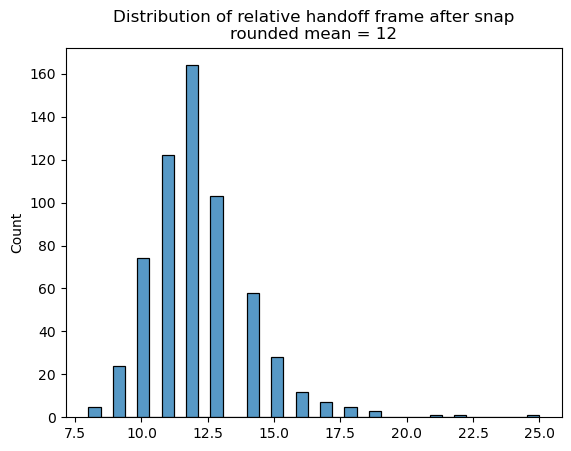

In [15]:
imputed_mean_handoff_frame = int(np.round(np.mean(np.array(rel_handoff_frames))))
plt.figure()
sns.histplot(rel_handoff_frames)
plt.title(f'Distribution of relative handoff frame after snap\nrounded mean = {imputed_mean_handoff_frame}')
plt.savefig(f'{settings['OUTPUT_FIGS']}relative_handoff_frame_after_snap.png')

In [16]:
# new dictionary of dictionaries that will hold much more info related to weak side defenders for gameplay keys
new_weak_side_details = {}

print('Extracting relevant weak side defender info ...')
for rownum, rowvals in weak_df_nonan.iterrows():
    gp, wdl, wlb, playdir_rbside = rowvals
    gp_df = mobile_NEW_handoff_snap.loc[mobile_NEW_handoff_snap['gameplayId'] == gp].reset_index(drop = True)
    
    # we have to standardize based on snap time to get relative frames again
    snap_frame = gp_df['frameId'].loc[gp_df['event'] == 'ball_snap'].values[0]

    # if there's a recorded handoff, grab it. if not (e.g. qb run), have to impute the frame when the read is taking place
    try:
        handoff_frame = gp_df['frameId'].loc[gp_df['event'] == 'handoff'].values[0] 
    except IndexError as e: 
        handoff_frame = snap_frame + imputed_mean_handoff_frame # mean imputation based on the mean calculated for the handoffs in the code chunk above

    frame_range = list(range(snap_frame, min(handoff_frame + 10, max(gp_df['frameId'])))) # we are interested from first to ten frames past the handoff, if possible

    handoff_frame_list = [handoff_frame for _ in range(len(frame_range))]

    play_dir, rb_side = playdir_rbside.split('_')
    play_dir_list = [play_dir for _ in range(len(frame_range))]
    rb_side_list = [rb_side for _ in range(len(frame_range))]

    # extract x annd y positions of wdl, wlb, and ball for the play across all frames of interest
    x_positions_wdl = list(gp_df['x'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == wdl)].values)
    x_positions_wlb = list(gp_df['x'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == wlb)].values)

    y_positions_wdl = list(gp_df['y'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == wdl)].values)
    y_positions_wlb = list(gp_df['y'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == wlb)].values)

    x_positions_ball = list(gp_df['x'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == 'football')].values)
    y_positions_ball = list(gp_df['y'].loc[(gp_df['frameId'].isin(frame_range)) & (gp_df['displayName'] == 'football')].values)

    # also capture where ball is on the line of scrimmage at the first frame
    los = plays['absoluteYardlineNumber'].loc[plays['gameplayId'] == gp].values[0]
    los_list = [los for _ in range(len(frame_range))]
    x_los_ball, y_los_ball = gp_df[['x', 'y']].loc[(gp_df['displayName'] == 'football') & 
                                            (gp_df['frameId'] == 1)].values[0] 
    x_los_ball_list = [x_los_ball for _ in range(len(frame_range))]
    y_los_ball_list = [y_los_ball for _ in range(len(frame_range))]
    
    # add to dictionary of dictionaries, using gameplay as key
    temp_dict_keys = ['frames', 'los', 'wdl_x_pos', 'wdl_y_pos', 'wlb_x_pos', 'wlb_y_pos', 'ball_x_pos', 'ball_y_pos', 
                      'ball_x_los', 'ball_y_los', 'play_dir', 'rb_side', 'handoff_frame']
    new_weak_side_details[gp] = dict(zip(temp_dict_keys, [frame_range, los_list, x_positions_wdl, y_positions_wdl, x_positions_wlb, y_positions_wlb,
                                                      x_positions_ball, y_positions_ball, x_los_ball_list, y_los_ball_list, play_dir_list, rb_side_list, handoff_frame_list]))

    if rownum % 100 == 0:
        print(f'{rownum}/{weak_df_nonan.shape[0]}')

print('Finished extracting relevant weak side defender info ...')

new_weak_side_details_df = pd.DataFrame.from_dict(new_weak_side_details, orient = 'index')
new_weak_side_details_df.to_csv(f'{settings['AGGREGATED_DATA']}new_weak_side_details_df.csv', index = True)


Extracting relevant weak side defender info ...
0/727
100/727
200/727
300/727
400/727
500/727
600/727
700/727
Finished extracting relevant weak side defender info ...


In [17]:
# explode the above dict of dicts into a much longer dataframe
new_weak_side_details_df = pd.read_csv(f'{settings['AGGREGATED_DATA']}new_weak_side_details_df.csv', index_col = 0)

# since reading in a dataframe that should have lists as values, have to convert from read-in strings back to lists
new_weak_side_details_df = new_weak_side_details_df.map(str_to_list)

# explode list entries to rows
mobile_new_exploded_weak = new_weak_side_details_df.explode(list(new_weak_side_details_df.columns))
mobile_new_exploded_weak['frames'] = mobile_new_exploded_weak['frames'].apply(lambda x: int(x))
mobile_new_exploded_weak.insert(column = 'gameplayId', value = list(mobile_new_exploded_weak.index), loc = 0)
mobile_new_exploded_weak.reset_index(drop = True, inplace = True)

# define lists to which we will add inside the for-loop, before later assigning as columns or dict values
new_growing_rel_frames = []
new_growing_rel_handoff_frames = []

# the goal here is to be sure we temporally line up all plays according to their ball snap
for gp in mobile_new_exploded_weak['gameplayId'].unique():
    # isolate play-specific data
    gp_df = mobile_new_exploded_weak.loc[mobile_new_exploded_weak['gameplayId'] == gp].reset_index(drop = True)
    min_frame_num = gp_df['frames'].min()

    # get rel frame for each frame in a play by subtracitng lowest frame num of that play
    rel_frames = list(gp_df['frames'] - min_frame_num)
    new_growing_rel_frames.extend(rel_frames) 

    # also identify the relative frame at which the handoff occurred
    rel_handoff_frame = gp_df['handoff_frame'][0] - min_frame_num
    new_growing_rel_handoff_frames.append(rel_handoff_frame)

# add relative frame into dataframe
mobile_new_exploded_weak.insert(loc = mobile_new_exploded_weak.shape[1], column = 'rel_frame', value = new_growing_rel_frames)
mobile_new_exploded_weak.to_csv(f'{settings['AGGREGATED_DATA']}new_weakside_details_exploded.csv', index = False)

# dict capturing gameplayIds and relative handoff frame for those plays
new_gp_rel_handoff_frame_dict = dict(zip(mobile_new_exploded_weak['gameplayId'].unique(), new_growing_rel_handoff_frames))

In [18]:
# here, we standardize weak side defenders' positions depending on the direcionality of the play and RB (rel to QB)
# this is necessary to bolster sample size but generalizes to a degree

new_rel_wdl_pos_x = []
new_rel_wdl_pos_y = []
new_rel_wlb_pos_x = []
new_rel_wlb_pos_y = []
new_rel_ball_pos_x = []
new_rel_ball_pos_y = []

# now, defenders will move toward a more positive relative x 
# outside defenders will start at positive y values and move toward zero (toward negative)

for rownum, rowvals in mobile_new_exploded_weak.iterrows():
    if rowvals['play_dir'] == 'left':
        new_rel_wdl_pos_x.append(float(rowvals['wdl_x_pos']) - float(rowvals['ball_x_los']))
        new_rel_wlb_pos_x.append(float(rowvals['wlb_x_pos']) - float(rowvals['ball_x_los']))
        new_rel_ball_pos_x.append(float(rowvals['ball_x_pos']) - float(rowvals['ball_x_los']))

        if rowvals['rb_side'] == 'right':
            new_rel_wdl_pos_y.append(float(rowvals['wdl_y_pos']) - float(rowvals['ball_y_los']))
            new_rel_wlb_pos_y.append(float(rowvals['wlb_y_pos']) - float(rowvals['ball_y_los']))
            new_rel_ball_pos_y.append(float(rowvals['ball_y_pos']) - float(rowvals['ball_y_los']))

        elif rowvals['rb_side'] == 'left':
            new_rel_wdl_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['wdl_y_pos']))
            new_rel_wlb_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['wlb_y_pos']))
            new_rel_ball_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['ball_y_pos']))
    
    elif rowvals['play_dir'] == 'right':
        new_rel_wdl_pos_x.append(float(rowvals['ball_x_los']) - float(rowvals['wdl_x_pos']))
        new_rel_wlb_pos_x.append(float(rowvals['ball_x_los']) - float(rowvals['wlb_x_pos']))
        new_rel_ball_pos_x.append(float(rowvals['ball_x_los']) - float(rowvals['ball_x_pos']))

        if rowvals['rb_side'] == 'right':
            new_rel_wdl_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['wdl_y_pos']))
            new_rel_wlb_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['wlb_y_pos']))
            new_rel_ball_pos_y.append(float(rowvals['ball_y_los']) - float(rowvals['ball_y_pos']))
        
        elif rowvals['rb_side'] == 'left':
            new_rel_wdl_pos_y.append(float(rowvals['wdl_y_pos']) - float(rowvals['ball_y_los']))
            new_rel_wlb_pos_y.append(float(rowvals['wlb_y_pos']) - float(rowvals['ball_y_los']))
            new_rel_ball_pos_y.append(float(rowvals['ball_y_pos']) - float(rowvals['ball_y_los']))

# create a new relative positioning dataframe based on these values
mobile_new_weak_rel_df = pd.DataFrame({'gameplayId': mobile_new_exploded_weak['gameplayId'],
                            'rel_frame': mobile_new_exploded_weak['rel_frame'], 
                            'rel_wdl_x':new_rel_wdl_pos_x, 'rel_wdl_y': new_rel_wdl_pos_y,
                           'rel_wlb_x': new_rel_wlb_pos_x, 'rel_wlb_y':new_rel_wlb_pos_y,
                           'rel_ball_x':new_rel_ball_pos_x, 'rel_ball_y':new_rel_ball_pos_y})

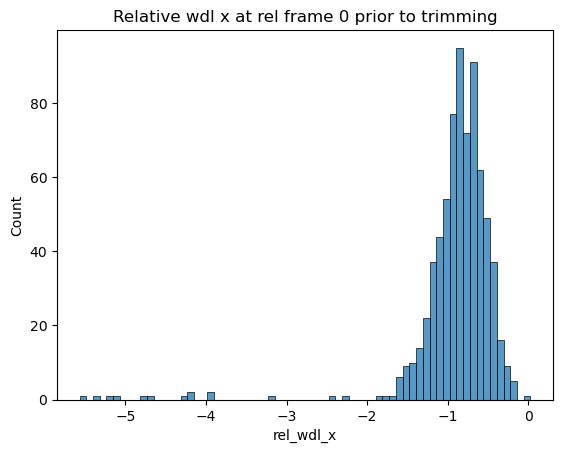

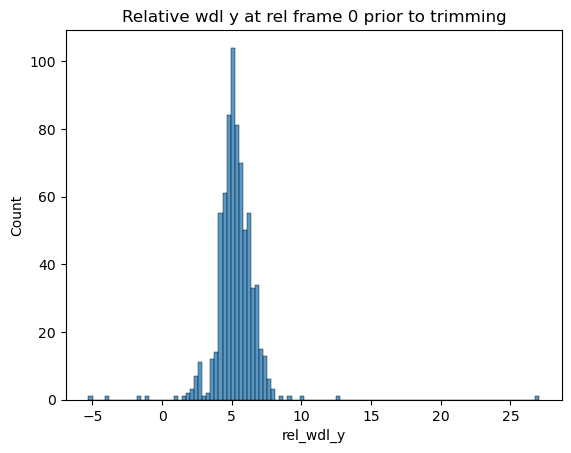

In [19]:
# plot density of relative weak side defenders' positions at relative frame 0
# currently there are 729 plays

mobile_new_starting_rel_wdl = mobile_new_weak_rel_df[['gameplayId', 'rel_wdl_x', 'rel_wdl_y']].loc[mobile_new_weak_rel_df['rel_frame'] == 0].reset_index(drop = True)

plt.figure()
sns.histplot(mobile_new_starting_rel_wdl['rel_wdl_x'])
plt.title('Relative wdl x at rel frame 0 prior to trimming')
plt.savefig(f'{settings['OUTPUT_FIGS']}relative_wdl_x_pretrimming.png')

plt.figure()
sns.histplot(mobile_new_starting_rel_wdl['rel_wdl_y'])
plt.title('Relative wdl y at rel frame 0 prior to trimming')
plt.savefig(f'{settings['OUTPUT_FIGS']}relative_wdl_y_pretrimming.png')


In [20]:
# filter based on histogram shapes
# trim outlier density from tails
# only include wdls who are within 2 years of the line of scrimmage (x)
# and between 2 and 8 yards away (y) from the ball on the line of scrimmage
mobile_new_filtered_starting_rel_wdl = mobile_new_starting_rel_wdl.loc[(mobile_new_starting_rel_wdl['rel_wdl_x'] < 0) & (mobile_new_starting_rel_wdl['rel_wdl_x'] > -2) &
                                                 (mobile_new_starting_rel_wdl['rel_wdl_y'] > 2) & (mobile_new_starting_rel_wdl['rel_wdl_y'] < 8)].reset_index(drop = True)


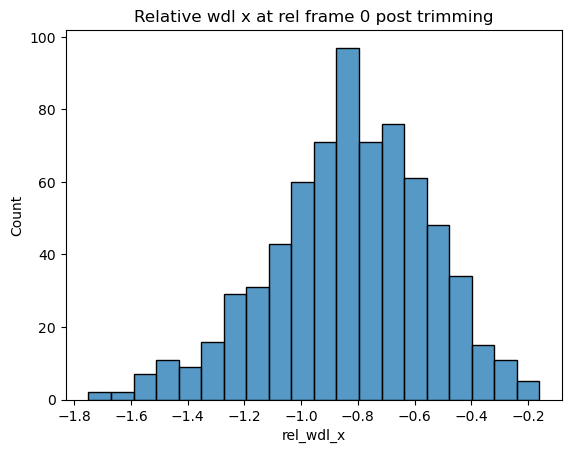

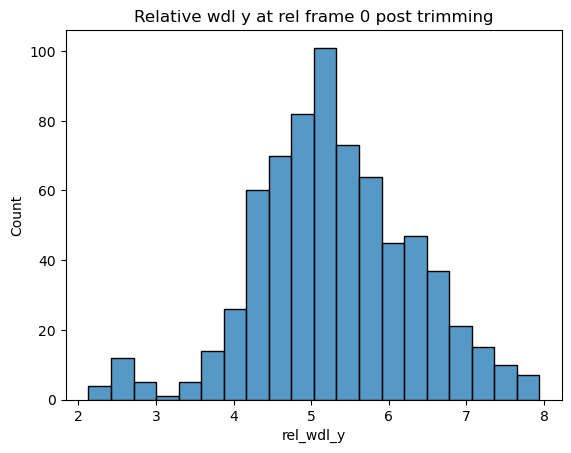

In [21]:
# MOBILE NEW DATAFRAME

plt.figure()
sns.histplot(mobile_new_filtered_starting_rel_wdl['rel_wdl_x'])
plt.title('Relative wdl x at rel frame 0 post trimming')
plt.savefig(f'{settings['OUTPUT_FIGS']}relative_wdl_x_posttrimming.png')

plt.figure()
sns.histplot(mobile_new_filtered_starting_rel_wdl['rel_wdl_y'])
plt.title('Relative wdl y at rel frame 0 post trimming')
plt.savefig(f'{settings['OUTPUT_FIGS']}relative_wdl_y_posttrimming.png')

In [22]:
# subset weak rel df to only include plays that are still present following this trimming process
# this leaves 699 plays
mobile_new_filt_weak_rel_df = mobile_new_weak_rel_df.loc[mobile_new_weak_rel_df['gameplayId'].isin(mobile_new_filtered_starting_rel_wdl['gameplayId'])].reset_index(drop = True)

# print(mobile_new_filt_weak_rel_df['gameplayId'].nunique()) 

In [23]:
def crash_or_contain_wdl(gp_df, frames_past = None, rel_handoff_dict = new_gp_rel_handoff_frame_dict):
    '''
    Use the relative positioning of wdl to classify his containment strategy
    '''
    
    snap_rel_x = gp_df['rel_wdl_x'].iloc[0]
    snap_rel_y = gp_df['rel_wdl_y'].iloc[0]

    rel_handoff_frame = int(rel_handoff_dict[gp_df['gameplayId'][0]])
    
    if not frames_past:
        frames_past = rel_handoff_frame

    rel_x_wdl_framespast = gp_df['rel_wdl_x'].iloc[frames_past-1]
    rel_y_wdl_framespast = gp_df['rel_wdl_y'].iloc[frames_past-1]

    rel_x_ball_framespast = gp_df['rel_ball_x'].iloc[frames_past-1]
    rel_y_ball_framespast = gp_df['rel_ball_y'].iloc[frames_past-1]

    end_rel_x = gp_df['rel_wdl_x'].iloc[-1]
    end_rel_y = gp_df['rel_wdl_y'].iloc[-1]

    if ((rel_y_wdl_framespast-5) >= rel_y_ball_framespast):
        # if defender goes >= 5 yards outside ball position, 'strong_contain'
        return 'strong_contain'
    
    elif ((rel_y_wdl_framespast-3) >= rel_y_ball_framespast):
        # if defender goes >= 3 yards outside , 'contain'
        return 'contain'
    
    elif ((rel_y_wdl_framespast-1) >= rel_y_ball_framespast):
        # if defender goes >= 1 yard outside, 'crash'
        return 'crash'
    
    else:
        return 'strong_crash'
    

def crash_or_contain_wlb(gp_df, frames_past = None, rel_handoff_dict = new_gp_rel_handoff_frame_dict):

    '''
    Use the relative positioning of wlb to classify his containment strategy
    '''
    
    snap_rel_x = gp_df['rel_wlb_x'].iloc[0]
    snap_rel_y = gp_df['rel_wlb_y'].iloc[0]

    rel_handoff_frame = int(rel_handoff_dict[gp_df['gameplayId'][0]])

    if not frames_past:
        frames_past = rel_handoff_frame

    rel_x_ball_framespast = gp_df['rel_ball_x'].iloc[frames_past-1]
    rel_y_ball_framespast = gp_df['rel_ball_y'].iloc[frames_past-1]

    rel_x_wlb_framespast = gp_df['rel_wlb_x'].iloc[frames_past-1]
    rel_y_wlb_framespast = gp_df['rel_wlb_y'].iloc[frames_past-1]

    end_rel_x = gp_df['rel_wlb_x'].iloc[-1]
    end_rel_y = gp_df['rel_wlb_y'].iloc[-1]

    if ((rel_y_wlb_framespast-5) >= rel_y_ball_framespast):
            # if defender goes >= 5 yards outside ball position, 'strong_contain'
            return 'strong_contain'
        
    elif ((rel_y_wlb_framespast-3) >= rel_y_ball_framespast):
        # if defender goes >= 3 yards outside , 'contain'
        return 'contain'
    
    elif ((rel_y_wlb_framespast-1) >= rel_y_ball_framespast):
        # if defender goes >= 1 yard outside, 'crash'
        return 'crash'
    
    else:
        return 'strong_crash'





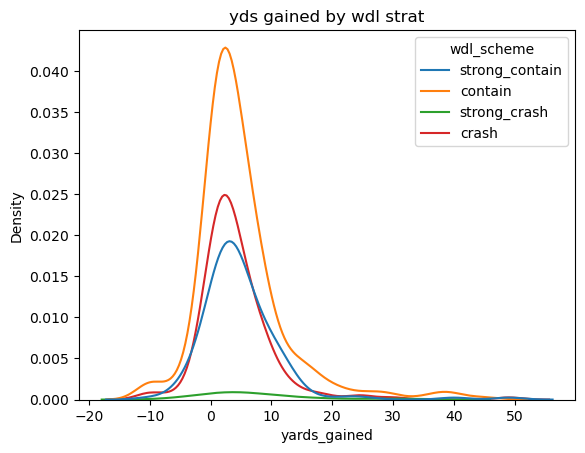

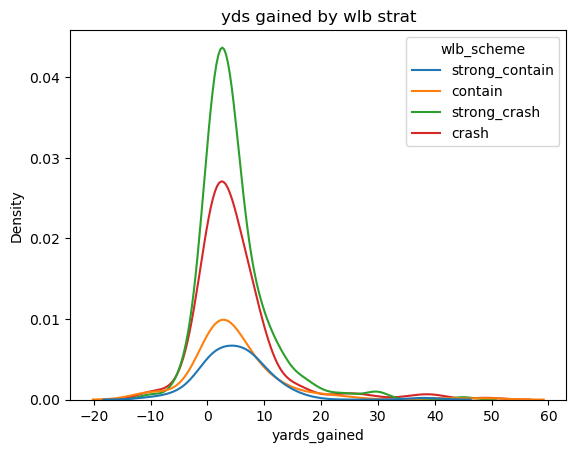

In [24]:
# assign wdl/wlb crash/contain strategies

mobile_new_filt_wdl_strats = []
mobile_new_filt_wlb_strats = []

# for each play, determine the crash/contain strategy for the wdl and wlb
for gp in mobile_new_filt_weak_rel_df['gameplayId'].unique():
    gp_df = mobile_new_filt_weak_rel_df.loc[mobile_new_filt_weak_rel_df['gameplayId'] == gp].reset_index(drop = True)
    mobile_new_filt_wdl_strats.append(crash_or_contain_wdl(gp_df = gp_df, rel_handoff_dict = new_gp_rel_handoff_frame_dict))
    mobile_new_filt_wlb_strats.append(crash_or_contain_wlb(gp_df = gp_df, rel_handoff_dict = new_gp_rel_handoff_frame_dict))

# create dictionary that has gameplays as keys and length two values: wdl strat, wlb strat
mobile_new_filt_gp_crash_contain_dict = dict(zip(mobile_new_filt_weak_rel_df['gameplayId'].unique(), zip(mobile_new_filt_wdl_strats, mobile_new_filt_wlb_strats)))

# find gameplayIds for plays belonging to certain wdl classification schemes
mobile_new_filt_strong_contain_inds_wdl = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'strong_contain']
mobile_new_filt_contain_inds_wdl = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'contain']
mobile_new_filt_strong_crash_inds_wdl = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'strong_crash']
mobile_new_filt_crash_inds_wdl = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'crash']

# find gameplayIds for plays belonging to certain wlb classification schemes
mobile_new_filt_strong_contain_inds_wlb = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'strong_contain']
mobile_new_filt_contain_inds_wlb = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'contain']
mobile_new_filt_strong_crash_inds_wlb = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'strong_crash']
mobile_new_filt_crash_inds_wlb = [k for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'crash']

# for each play, add the playresult to the respective wdl list (depending on what strat the wdl used on that play)
mobile_new_filt_strong_contain_play_res_wdl = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'strong_contain']
mobile_new_filt_contain_play_res_wdl = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'contain']
mobile_new_filt_strong_crash_play_res_wdl = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'strong_crash']
mobile_new_filt_crash_play_res_wdl = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[0] == 'crash']

# for each play, add the playresult to the respective wlb list (depending on what strat the wlb used on that play)
mobile_new_filt_strong_contain_play_res_wlb = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'strong_contain']
mobile_new_filt_contain_play_res_wlb = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'contain']
mobile_new_filt_strong_crash_play_res_wlb = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'strong_crash']
mobile_new_filt_crash_play_res_wlb = [plays['playResult'].loc[plays['gameplayId'] == k].values[0] for k, v in mobile_new_filt_gp_crash_contain_dict.items() if v[1] == 'crash']

# create dataframe of play results by wdl strat
mobile_new_filt_play_res_by_contain_df_wdl = pd.DataFrame.from_dict({'strong_contain':mobile_new_filt_strong_contain_play_res_wdl,
                                       'contain':mobile_new_filt_contain_play_res_wdl,
                                       'strong_crash':mobile_new_filt_strong_crash_play_res_wdl,
                                       'crash':mobile_new_filt_crash_play_res_wdl}, orient='index').T

# create dataframe of play results by wlb strat
mobile_new_filt_play_res_by_contain_df_wlb = pd.DataFrame.from_dict({'strong_contain':mobile_new_filt_strong_contain_play_res_wlb,
                                       'contain':mobile_new_filt_contain_play_res_wlb,
                                       'strong_crash':mobile_new_filt_strong_crash_play_res_wlb,
                                       'crash':mobile_new_filt_crash_play_res_wlb}, orient='index').T

# melt dataframes for easier plotting
mobile_new_filt_play_res_by_contain_df_melt_wdl = mobile_new_filt_play_res_by_contain_df_wdl.melt(var_name='wdl_scheme', value_name='yards_gained').dropna()
mobile_new_filt_play_res_by_contain_df_melt_wlb = mobile_new_filt_play_res_by_contain_df_wlb.melt(var_name='wlb_scheme', value_name='yards_gained').dropna()

plt.figure()
sns.kdeplot(mobile_new_filt_play_res_by_contain_df_melt_wdl, hue='wdl_scheme', x = 'yards_gained')
plt.title('yds gained by wdl strat')
plt.savefig(f'{settings['OUTPUT_FIGS']}yds_gained_by_wdl_strat.png')

plt.figure()
sns.kdeplot(mobile_new_filt_play_res_by_contain_df_melt_wlb, hue='wlb_scheme', x = 'yards_gained')
plt.title('yds gained by wlb strat')
plt.savefig(f'{settings['OUTPUT_FIGS']}yds_gained_by_wlb_strat.png')


/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/462330767.py:24: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(mobile_new_wdl_wlb_df, hue='joint_strats', x = 'yds_gained')
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/462330767.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(mobile_new_pos[posnum], mobile_new_average_res[posnum] - 0.5, mobile_new_combo_counts[posnum],


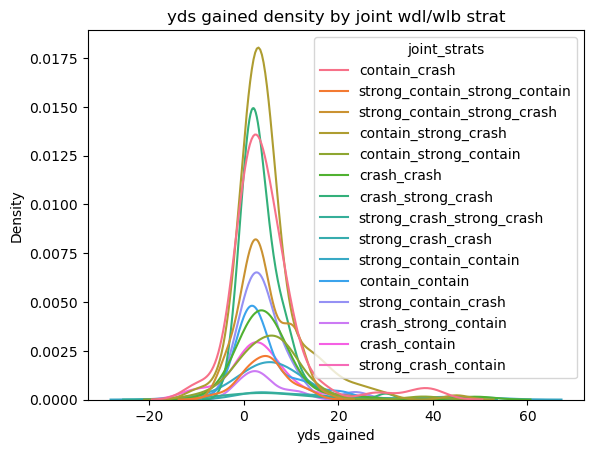

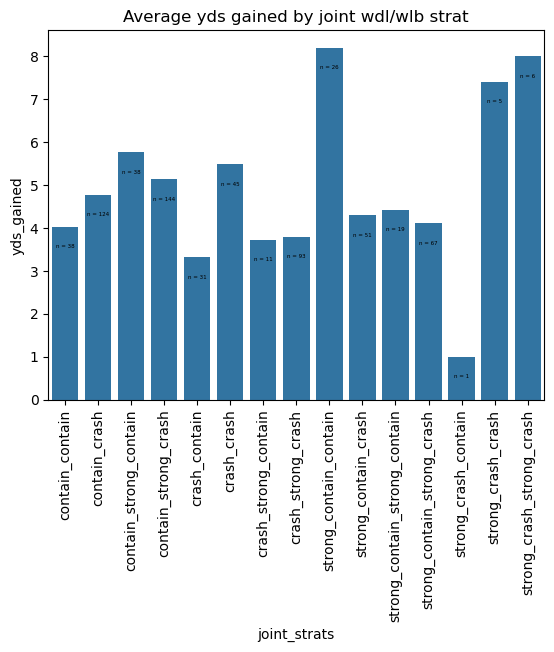

In [25]:
# perform similar analyses but with joint wdl/wlb strats 
mobile_new_wdl_wlb_df = pd.DataFrame.from_dict(mobile_new_filt_gp_crash_contain_dict, orient = 'index', 
                                               columns=['wdl_strat', 'wlb_strat']).reset_index(drop = False)
mobile_new_wdl_wlb_df.rename(columns = {'index':'gameplayId'}, inplace=True)

mobile_new_yds_gained = [plays['playResult'].loc[plays['gameplayId'] == gp].values[0] for gp in mobile_new_wdl_wlb_df['gameplayId']]
mobile_new_wdl_wlb_df.insert(loc = mobile_new_wdl_wlb_df.shape[1], column = 'yds_gained', value = mobile_new_yds_gained)

mobile_new_joint_strats = mobile_new_wdl_wlb_df.apply(lambda row: f"{row['wdl_strat']}_{row['wlb_strat']}", axis = 1)

mobile_new_wdl_wlb_df.insert(loc = mobile_new_wdl_wlb_df.shape[1], column = 'joint_strats', value = mobile_new_joint_strats)

# print(wdl_wlb_df.groupby('joint_strats')['yds_gained'].mean())
mobile_new_average_res = mobile_new_wdl_wlb_df.groupby('joint_strats')['yds_gained'].mean()

mobile_new_combo_counts = mobile_new_wdl_wlb_df.groupby('joint_strats')['gameplayId'].agg('count')
mobile_new_combo_counts = [f'n = {str(count)}' for count in mobile_new_combo_counts.values]
mobile_new_pos = range(len(mobile_new_combo_counts))

mobile_new_wdl_wlb_df.to_csv(f'{settings['AGGREGATED_DATA']}mobile_new_wdl_wlb_df.csv', index = False)


plt.figure()
sns.kdeplot(mobile_new_wdl_wlb_df, hue='joint_strats', x = 'yds_gained')
plt.title('yds gained density by joint wdl/wlb strat')
plt.savefig(f'{settings['OUTPUT_FIGS']}yds_gained_density_by_joint_strat.png')

plt.figure()
ax = sns.barplot(mobile_new_average_res)
for posnum, lab in zip(mobile_new_pos, ax.get_xticklabels()):
    ax.text(mobile_new_pos[posnum], mobile_new_average_res[posnum] - 0.5, mobile_new_combo_counts[posnum], 
            horizontalalignment = 'center', size = 4)
plt.xticks(rotation = 90)
plt.title('Average yds gained by joint wdl/wlb strat')
plt.savefig(f'{settings['OUTPUT_FIGS']}average_yds_gained_bars_by_joint_strat.png')




In [26]:
mobile_new_average_res.to_csv(f'{settings['AGGREGATED_DATA']}/mobile_new_average_res.csv', index = True)

In [27]:
# recovering all tracking info from above-subsetted tracking dataframe using each play's relevant snap-to-handoff frames

# subset mobile_new_exploded_weak to account for the outliers that were filtered above: 
filt_mobile_new_exploded_weak = mobile_new_exploded_weak.loc[mobile_new_exploded_weak['gameplayId'].isin(mobile_new_filt_weak_rel_df['gameplayId'])].reset_index(drop = True)

snap_frames = list(filt_mobile_new_exploded_weak.groupby('gameplayId')['frames'].min())
handoff_frames = list(filt_mobile_new_exploded_weak.drop_duplicates(subset = 'gameplayId')['handoff_frame'].values)
gps = list(filt_mobile_new_exploded_weak['gameplayId'].unique())

gp_frames_to_train = {gp:list(range(int(start_frame), int(end_frame) + 1)) 
                      for gp, start_frame, end_frame in zip(gps, snap_frames, handoff_frames)}

growing_index_list = []
print('Beginning to aggregate raw data for training ...')
for ind, k_v in enumerate(gp_frames_to_train.items()):
    gp, frame_range = k_v # unpack 
    
    # make growing list of row indices of mobile_NEW_handoff_snap that we'll want to use to subset
    temp_index_list = mobile_NEW_handoff_snap.index[(mobile_NEW_handoff_snap['gameplayId'] == gp) &
                                     (mobile_NEW_handoff_snap['displayName'] != 'football') &
                                     (mobile_NEW_handoff_snap['frameId'].isin(frame_range))].tolist()
    
    growing_index_list.extend(temp_index_list)
    
    if ind % 100 == 0:
        print(f'{ind}/{len(gp_frames_to_train)}')
print('Finished aggregating raw data for training ...')

mobile_new_gp_tracking_frames_train = mobile_NEW_handoff_snap.iloc[growing_index_list, :].reset_index(drop = True)


print('Finding relative frames ...')
# next, add in the relative frames (vs snap) to this big dataframe
mobile_rel_frames_list = []
for ind, gp in enumerate(mobile_new_gp_tracking_frames_train['gameplayId'].unique()):
    gp_df = mobile_new_gp_tracking_frames_train.loc[mobile_new_gp_tracking_frames_train['gameplayId'] == gp].reset_index(drop = True)
    min_frame = gp_df['frameId'].min()
    rel_frames = gp_df['frameId'] - min_frame
    mobile_rel_frames_list.extend(list(rel_frames))

    if ind % 100 == 0:
        print(f'{ind}/{mobile_new_gp_tracking_frames_train['gameplayId'].nunique()}')
print('Finished finding relative frames ...')

mobile_new_gp_tracking_frames_train.insert(loc = mobile_new_gp_tracking_frames_train.shape[1], 
                                           value = mobile_rel_frames_list,
                                           column = 'rel_frame')



Beginning to aggregate raw data for training ...
0/699
100/699
200/699
300/699
400/699
500/699
600/699
Finished aggregating raw data for training ...
Finding relative frames ...
0/699
100/699
200/699
300/699
400/699
500/699
600/699
Finished finding relative frames ...


In [28]:
# we have to supply a snap_only tracking dataframe for find_play_rb_dir, so subset to only include snap frames
mobile_new_gp_tracking_frames_train_snap = mobile_new_gp_tracking_frames_train.loc[mobile_new_gp_tracking_frames_train['event'] == 'ball_snap'].reset_index(drop = True)

# finding play and rb directions for gameplays
mobile_gp_play_rb_dir_dict = dict(zip(mobile_new_gp_tracking_frames_train_snap['gameplayId'].unique(), 
                               [find_play_rb_dir(gp = gp, tracking_df=mobile_new_gp_tracking_frames_train_snap, players_df=players)
                                                                                     for gp in mobile_new_gp_tracking_frames_train_snap['gameplayId'].unique()]))


# we also need a dictionary that tells us the position of the football on the line of scrimmage (i.e. los x and y)
mobile_football_tracking_train = mobile_NEW_handoff_snap.loc[(mobile_NEW_handoff_snap['displayName'] == 'football') & 
                                       (mobile_NEW_handoff_snap['gameplayId'].isin(mobile_gp_play_rb_dir_dict.keys()))].reset_index(drop = True)

mobile_football_starting_pos_dict = {}
for gp in mobile_football_tracking_train['gameplayId'].unique():
    # starting position of ball is assumed to be where the ball was positioned at frame 1
    starting_x, starting_y = mobile_football_tracking_train[['x', 'y']].loc[(mobile_football_tracking_train['gameplayId'] == gp) &
                                                                     (mobile_football_tracking_train['frameId'] == 1)].values[0]
    mobile_football_starting_pos_dict[gp] = [starting_x, starting_y]

In [29]:
# generate x and y positionings of ALL players relative to the ball's starting position
# accounting for the directionality of the play and of the shotgun formation

mobile_train_relx = []
mobile_train_rely = []

for rownum, rowvals in mobile_new_gp_tracking_frames_train.iterrows():

    gp = rowvals['gameplayId']

    football_start_x, football_start_y = mobile_football_starting_pos_dict[gp]
    play_dir, rb_side = mobile_gp_play_rb_dir_dict[gp]

    if play_dir == 'left':
        mobile_train_relx.append(float(rowvals['x']) - football_start_x)

        if rb_side == 'right':
            mobile_train_rely.append(float(rowvals['y']) - football_start_y)

        elif rb_side == 'left':
            mobile_train_rely.append(football_start_y - float(rowvals['y']))
    
    elif play_dir == 'right':
        mobile_train_relx.append(football_start_x - float(rowvals['x']))

        if rb_side == 'right':
            mobile_train_rely.append(football_start_y - float(rowvals['y']))
        
        elif rb_side == 'left':
            mobile_train_rely.append(float(rowvals['y']) - football_start_y)


if 'rel_x' not in list(mobile_new_gp_tracking_frames_train.columns):
    mobile_new_gp_tracking_frames_train.insert(column = 'rel_x', value = mobile_train_relx, loc = mobile_new_gp_tracking_frames_train.shape[1])
    mobile_new_gp_tracking_frames_train.insert(column = 'rel_y', value = mobile_train_rely, loc = mobile_new_gp_tracking_frames_train.shape[1])
mobile_new_gp_tracking_frames_train.to_csv(f'{settings['AGGREGATED_DATA']}mobile_new_gp_tracking_frames_train.csv', index = False)

In [30]:
# clean dataframe of rel positions of the wlb and wdl in the frames leading up to the handoff:
mobile_keep_weak_inds = []

for gp in mobile_new_filt_weak_rel_df['gameplayId'].unique():
    rel_handoff_frame = int(new_gp_rel_handoff_frame_dict[gp])
    snap_to_handoff_frames = list(range(0, rel_handoff_frame + 1))
    temp_keep_weak_inds = mobile_new_filt_weak_rel_df.index[(mobile_new_filt_weak_rel_df['gameplayId'] == gp) &
                                                (mobile_new_filt_weak_rel_df['rel_frame'].isin(snap_to_handoff_frames))].tolist()
    mobile_keep_weak_inds.extend(temp_keep_weak_inds)


mobile_snap_to_handoff_new_weak_rel_df = mobile_new_filt_weak_rel_df.loc[mobile_keep_weak_inds, :].reset_index(drop = True)

    

In [31]:
mobile_new_gp_tracking_frames_train = pd.read_csv(f'{settings['AGGREGATED_DATA']}mobile_new_gp_tracking_frames_train.csv', index_col= False)
mobile_new_gp_tracking_frames_train = mobile_new_gp_tracking_frames_train.loc[mobile_new_gp_tracking_frames_train['rel_frame'].isin(list(range(0, 9)))].reset_index(drop = True)

In [32]:
# before we can use SMOTE, we have to remove NaNs from our dataframe
# this means we lose some information by truncating all plays to the length of the shortest play,
# thus preventing NaNs from emerging as features in rel_frames beyond the length of a play
# this ultimately comes down to a trade-off of losing information on each play, vs losing eligible plays
# I elected to go with the former because of the already very limited sample size
# we thus truncate plays to include all frames up to and including the 9th relative frame (if we were to count the first relativce frame as 1)
mobile_new_gp_tracking_frames_train = pd.read_csv(f'{settings['AGGREGATED_DATA']}mobile_new_gp_tracking_frames_train.csv', index_col= False)
mobile_new_gp_tracking_frames_train = mobile_new_gp_tracking_frames_train.loc[mobile_new_gp_tracking_frames_train['rel_frame'].isin(list(range(0, 9)))].reset_index(drop = True)

# we care about whether the player is on offense or defense when finding euclidean distances
mobile_gp_possession_team_dict = {gp:plays['possessionTeam'].loc[plays['gameplayId'] == gp].values[0] for gp in mobile_new_gp_tracking_frames_train['gameplayId'].unique()}
mobile_off_or_def_list = ['OFF' if rowvals['club'] == mobile_gp_possession_team_dict[rowvals['gameplayId']] 
                          else 'DEF' for rownum, rowvals in mobile_new_gp_tracking_frames_train.iterrows()]
mobile_new_gp_tracking_frames_train.insert(loc = mobile_new_gp_tracking_frames_train.shape[1],
                                           column = 'off_or_def', 
                                           value = mobile_off_or_def_list)

In [33]:
# euclidean distances from origin point of ball on each play
# these distances will be used as the input to our yards-gained regressors
euc_dists = mobile_new_gp_tracking_frames_train.apply(lambda row: math.sqrt(row['rel_x']**2 + row['rel_y']**2), axis = 1)
mobile_new_gp_tracking_frames_train.insert(loc = mobile_new_gp_tracking_frames_train.shape[1],
                                           column = 'euc_dists', 
                                           value = euc_dists)

# in column named 0, have gameplayId, offense/defense, and relative frame
# in column named 1, have the 11 euc distances of the players on that offense/defense from the origin in that frame of the gameplay
grouped_dist_df = pd.DataFrame(mobile_new_gp_tracking_frames_train.groupby(['gameplayId', 'off_or_def', 'rel_frame'])['euc_dists'])

# unpacking the info stored in the column named 0
gps = [vals[0] for vals in grouped_dist_df[0]]
off_or_def = [vals[1] for vals in grouped_dist_df[0]]
rel_frame = [vals[2] for vals in grouped_dist_df[0]]

# for each play, sort the distances from the origin from smallest to largest
sorted_eucs = [sorted(vals) for vals in grouped_dist_df[1]]
sorted_grouped_dist_df = pd.DataFrame({'gameplayId':gps,
                                       'off_or_def':off_or_def,
                                       'rel_frame':rel_frame,
                                       'sorted_eucs':sorted_eucs})
eucs_df = pd.DataFrame(sorted_grouped_dist_df['sorted_eucs'].to_list(), columns = [f'closest_{x}' for x in range(0, 11)])
sorted_grouped_dist_df = pd.concat([sorted_grouped_dist_df, eucs_df], axis = 1)
sorted_grouped_dist_df.drop(columns = 'sorted_eucs', inplace = True)

# for each rel_frame of each gameplay, make a row with the distances of all 11 defenders from origin
sorted_grouped_dist_df_def = sorted_grouped_dist_df.loc[sorted_grouped_dist_df['off_or_def'] == 'DEF'].reset_index(drop = True)

# widen the dataframe by pivoting the rel_frame from a feature of a row to a column grouper
wide_sorted_grouped_dist_df_def = sorted_grouped_dist_df_def.pivot_table(values = list(sorted_grouped_dist_df_def.columns[3:sorted_grouped_dist_df_def.shape[1]]), 
                                                                         index = ['gameplayId'], columns = ['rel_frame'])

# since we have 9 frames per play and 11 defenders per play, we have 99 distances per play
wide_sorted_grouped_dist_df_def.columns = [f'{i}_{j}' for i, j in wide_sorted_grouped_dist_df_def.columns]


accuracy = 0.71


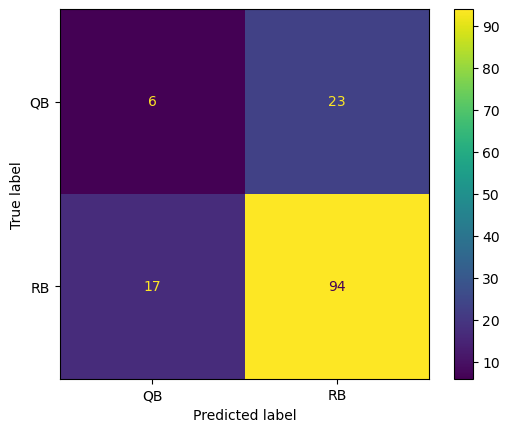

correlation = 0.3471708957061738
correlation = 0.2216190643212941
5.641344053888335


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

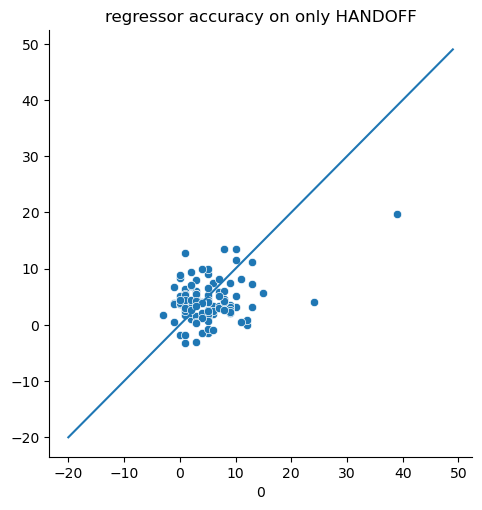

<Figure size 640x480 with 0 Axes>

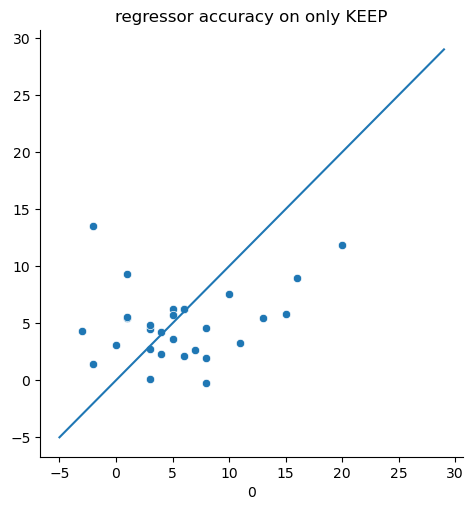

In [34]:
# the classifier will predict handoff vs qb keeper
# its feature space will include the relative positionings of weak side defenders in the frames leading up to the read
# in a similar way to how the euclidean distance features were generated for the regressor, drop all frames with NaNs (see above tradeoff)
# then widen dataframe to include relative positions of wdl and wlb across each possible rel frame for a gameplay
X_mobile_read_classifier = mobile_snap_to_handoff_new_weak_rel_df[['gameplayId', 'rel_frame', 'rel_wdl_x', 'rel_wdl_y', 'rel_wlb_x', 'rel_wlb_y']]
X_mobile_read_classifier = X_mobile_read_classifier.pivot_table(index = 'gameplayId', values = ['rel_wdl_x', 'rel_wdl_y', 'rel_wlb_x', 'rel_wlb_y'], columns = 'rel_frame')
X_mobile_read_classifier.columns = [f'{i}_{j}' for i, j in X_mobile_read_classifier.columns]

colnumnan_dict = {}
for colname in X_mobile_read_classifier.columns:    
    colnumnan_dict[colname] = sum([pd.isnull(measure) for measure in X_mobile_read_classifier.loc[:, colname]])

X_mobile_read_classifier_nan_cols = [k for k, v in colnumnan_dict.items() if v > 0]

X_mobile_read_classifier.drop(columns = X_mobile_read_classifier_nan_cols, inplace=True) # remove columns that have any nans in them


# generate handoff vs keep outcomes:
y_mobile_read_classifier = [gp_bc_pos_dict[gp] for gp in X_mobile_read_classifier.index]

# outcome variables
def convert_to_labels(bc):
    if bc == 'QB':
        return 0
    elif bc == 'RB':
        return 1
    
y_mobile_read_classifier = list(map(convert_to_labels, y_mobile_read_classifier))

# default parameters
mobile_read_clf = xgb.XGBClassifier()

# we'll have train, test, and holdout in the end
# here we set aside 20% of all 699 plays as HOLDOUT plays that we'll ultimately predict on
X_mobile_read_USE, X_mobile_read_HOLDOUT, y_mobile_read_USE, y_mobile_read_HOLDOUT = train_test_split(
    X_mobile_read_classifier,
    y_mobile_read_classifier,
    test_size = 0.20,
    random_state = 42
)

# divide the USE data (i.e. not held out) into train and test (75-25)
# will not use this data for explicit model training but will use it for tracing median positonings of weak side defenders
X_mobile_read_train, X_mobile_read_test, y_mobile_read_train, y_mobile_read_test = train_test_split(
    X_mobile_read_USE,
    y_mobile_read_USE,
    test_size = 0.25,
    random_state = 42
)

# use SMOTE to generate more data
mobile_sm = SMOTE(random_state = 42, k_neighbors=3) # k = 3 nearest neighbors


X_mobile_train_sm, y_mobile_train_sm = mobile_sm.fit_resample(X_mobile_read_train, y_mobile_read_train)

# X_mobile_read_classifier_sm, y_mobile_read_classifier_sm = mobile_sm.fit_resample(X_mobile_read_USE, y_mobile_read_USE)
# print(Counter(y_mobile_read_USE))

mobile_sm_read_clf = xgb.XGBClassifier()

# # divide SMOTE data into train test split
# X_mobile_train_sm, X_mobile_test_sm, y_mobile_train_sm, y_mobile_test_sm = train_test_split(
#     X_mobile_read_classifier_sm,
#     y_mobile_read_classifier_sm,
#     test_size = 0.25,
#     random_state = 42
# )

mobile_sm_read_clf.fit(X_mobile_train_sm, y_mobile_train_sm)
pickle.dump(mobile_sm_read_clf, open(f'{settings['MODELS']}mobile_sm_read_clf.pkl', 'wb'))


mobile_sm_pred_read = mobile_sm_read_clf.predict(X_mobile_read_test)

# mobile_sm_pred_read = mobile_sm_read_clf.predict(X_mobile_test_sm)

accuracy_score = metrics.accuracy_score(y_true = y_mobile_read_test, y_pred = mobile_sm_pred_read)
sm_cm = metrics.confusion_matrix(y_true = y_mobile_read_test, y_pred = mobile_sm_pred_read)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix = sm_cm, display_labels = ['QB', 'RB'])
print(f'accuracy = {np.round(accuracy_score, 2)}')
disp.plot()
plt.show()
plt.savefig(f'{settings['OUTPUT_FIGS']}classifier_confusion_matrix.png')



# YARDS GAINED REGRESSION
X_mobile_yds_gained = wide_sorted_grouped_dist_df_def
y_mobile_yds_gained = [plays['playResult'].loc[plays['gameplayId'] == gp].values[0] for gp in X_mobile_read_classifier.index]

# in a similar way, hold out 20% of this data (it will be the same heldout gameplays as above)
X_mobile_yds_gained_USE, X_mobile_yds_gained_HOLDOUT, y_mobile_yds_gained_USE, y_mobile_yds_gained_HOLDOUT = train_test_split(
    X_mobile_yds_gained,
    y_mobile_yds_gained,
    test_size = 0.20,
    random_state = 42
)

# only split the 80% USE data into train/test (75-25)
X_mobile_yds_gained_train, X_mobile_yds_gained_test, y_mobile_yds_gained_train, y_mobile_yds_gained_test = train_test_split(
    X_mobile_yds_gained_USE,
    y_mobile_yds_gained_USE,
    test_size = 0.25,
    random_state = 42
)

y_mobile_yds_gained_train = pd.DataFrame(y_mobile_yds_gained_train, index = X_mobile_yds_gained_train.index)
y_mobile_yds_gained_test = pd.DataFrame(y_mobile_yds_gained_test, index = X_mobile_yds_gained_test.index)

rb_gp_inds = [k for k, v in gp_bc_pos_dict.items() if v == 'RB']
qb_gp_inds = [k for k, v in gp_bc_pos_dict.items() if v == 'QB']

# divide the training data into handoff and keep training data based on whether it was a handoff or keeper
X_mobile_yds_gained_train_HANDOFF = X_mobile_yds_gained_train[X_mobile_yds_gained_train.index.isin(rb_gp_inds)]
X_mobile_yds_gained_train_KEEP = X_mobile_yds_gained_train[X_mobile_yds_gained_train.index.isin(qb_gp_inds)]
y_mobile_yds_gained_train_HANDOFF = y_mobile_yds_gained_train[y_mobile_yds_gained_train.index.isin(rb_gp_inds)]
y_mobile_yds_gained_train_KEEP = y_mobile_yds_gained_train[y_mobile_yds_gained_train.index.isin(qb_gp_inds)]

# same with the test data (we're not blinded to read classification yet)
X_mobile_yds_gained_test_HANDOFF = X_mobile_yds_gained_test[X_mobile_yds_gained_test.index.isin(rb_gp_inds)]
X_mobile_yds_gained_test_KEEP = X_mobile_yds_gained_test[X_mobile_yds_gained_test.index.isin(qb_gp_inds)]
y_mobile_yds_gained_test_HANDOFF = y_mobile_yds_gained_test[y_mobile_yds_gained_test.index.isin(rb_gp_inds)]
y_mobile_yds_gained_test_KEEP = y_mobile_yds_gained_test[y_mobile_yds_gained_test.index.isin(qb_gp_inds)]

# train the two regressors
mobile_yds_gained_regressor_HANDOFF = xgb.XGBRegressor(max_depth = 5, num_parallel_tree = 5)
mobile_yds_gained_regressor_KEEP = xgb.XGBRegressor(max_depth = 5, num_parallel_tree = 5)
mobile_yds_gained_regressor_HANDOFF.fit(X_mobile_yds_gained_train_HANDOFF, y_mobile_yds_gained_train_HANDOFF)
mobile_yds_gained_regressor_KEEP.fit(X_mobile_yds_gained_train_KEEP, y_mobile_yds_gained_train_KEEP)

# save trained regressors:
pickle.dump(mobile_yds_gained_regressor_HANDOFF, open(f'{settings['MODELS']}mobile_yds_gained_regressor_HANDOFF.pkl', 'wb'))
pickle.dump(mobile_yds_gained_regressor_KEEP, open(f'{settings['MODELS']}mobile_yds_gained_regressor_KEEP.pkl', 'wb'))

# predict on test data
mobile_yds_gained_pred_HANDOFF = mobile_yds_gained_regressor_HANDOFF.predict(X_mobile_yds_gained_test_HANDOFF)
mobile_yds_gained_pred_KEEP = mobile_yds_gained_regressor_KEEP.predict(X_mobile_yds_gained_test_KEEP)

plt.figure()
sns.relplot(x = y_mobile_yds_gained_test_HANDOFF.iloc[:, 0], y = mobile_yds_gained_pred_HANDOFF)
sns.lineplot(x = list(range(-20, 50)), y = list(range(-20, 50)))

print(f'correlation = {np.corrcoef(x = y_mobile_yds_gained_test_HANDOFF.iloc[:, 0], y = mobile_yds_gained_pred_HANDOFF)[0,1]}')
plt.title('regressor accuracy on only HANDOFF')
plt.savefig(f'{settings['OUTPUT_FIGS']}handoff_test_correlation.png')


plt.figure()
sns.relplot(x = y_mobile_yds_gained_test_KEEP.iloc[:, 0], y = mobile_yds_gained_pred_KEEP)
sns.lineplot(x = list(range(-5, 30)), y = list(range(-5, 30)))

print(f'correlation = {np.corrcoef(x = y_mobile_yds_gained_test_KEEP.iloc[:, 0], y = mobile_yds_gained_pred_KEEP)[0,1]}')
print(metrics.mean_squared_error(y_true = y_mobile_yds_gained_test_KEEP, y_pred = mobile_yds_gained_pred_KEEP, squared = False))

plt.title('regressor accuracy on only KEEP')
plt.savefig(f'{settings['OUTPUT_FIGS']}keeper_test_correlation.png')



In [47]:
y_mobile_test_yds_gained_handoff_df = pd.DataFrame({'true_yds_gained':y_mobile_yds_gained_test_HANDOFF.iloc[:, 0], 
                                                    'pred_yds_gained': mobile_yds_gained_pred_HANDOFF})
y_mobile_test_yds_gained_handoff_df.to_csv(f'{settings['AGGREGATED_DATA']}/y_mobile_test_yds_gained_handoff_df.csv')
y_mobile_test_yds_gained_keep_df = pd.DataFrame({'true_yds_gained': y_mobile_yds_gained_test_KEEP.iloc[:, 0], 
                                                 'pred_yds_gained': mobile_yds_gained_pred_KEEP})
y_mobile_test_yds_gained_keep_df.to_csv(f'{settings['AGGREGATED_DATA']}/y_mobile_test_yds_gained_keep_df.csv')

In [36]:
    
def evolving_heatmap_weak(rel_df, savename_prefix = '', filt_by_strat = None):
    '''
    Create animated heatmaps showing movement patterns of weak side defenders
    '''

    temp_pics_folder = f"{settings['OUTPUT_GIFS']}temp_images/"
    if not os.path.exists(temp_pics_folder):
        os.mkdir(temp_pics_folder)

    def combine_plots(savename):
        gif_dir = f"{settings['OUTPUT_GIFS']}evolving_heatmaps/"

        file_paths = glob.glob(f'{temp_pics_folder}/*.png')
        
        frame_nums = [int(re.findall(pattern = '.*frame(\\d+).png', string = path)[0]) for path in file_paths]
        path_frame_dict = dict(zip(file_paths, frame_nums))
        path_frame_dict = {k:v for k, v in sorted(path_frame_dict.items(), key = lambda x: x[1])}
        sorted_paths = list(path_frame_dict.keys())

        pil_images = [Image.open(im) for im in sorted_paths]
        first_frame = pil_images[0]
        first_frame.save(os.path.join(gif_dir, savename), format = 'GIF', append_images = pil_images,
                        save_all = True, duration = 100, loop = 1)
        
        # remove images at the end
        for img in file_paths:
            os.remove(img)

    def individual_plots(rel_df, position):
        
        median_x_pos = []
        median_y_pos = []

        # if we want to only plot certain strategies
        if filt_by_strat:
            pos_index = 0 if position == 'wdl' else 1 # dict values are arranged (wdl_strat, wlb_strat)
            rel_df = rel_df.loc[rel_df['gameplayId'].isin([gp for gp, strat in mobile_new_filt_gp_crash_contain_dict.items() if strat[pos_index] == filt_by_strat])].reset_index(drop = True)

        position_df = rel_df[['rel_frame', f'rel_{position}_x', f'rel_{position}_y']] # track players individually at first

        for frame in position_df['rel_frame'].unique(): 

            frame_df = position_df.loc[position_df['rel_frame'] == frame].reset_index(drop = True)

            # find median frames so that we can trace and later force
            median_frame_x = frame_df[f'rel_{position}_x'].median()
            median_frame_y = frame_df[f'rel_{position}_y'].median()

            median_x_pos.append(median_frame_x)
            median_y_pos.append(median_frame_y)

            fig, ax = plt.subplots()
            
            ax.set(xlim = (-2.5, 2.5), ylim = (-2.5, 10))
            ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
            
            ax.scatter(x = median_x_pos, y = median_y_pos)
            
            up_pos = position.upper()
            write_position = f'{up_pos[0]}S{up_pos[1:3]}'
            plt.title(f'Position distribution of {filt_by_strat} {write_position}, frame {frame}')

            plot_savename = f'{position}_density_heamtap_frame{int(frame)}.png'

            plt.savefig(os.path.join(temp_pics_folder, plot_savename), dpi = 200)

            plt.close()

            if frame == position_df['rel_frame'].max():
                combine_plots(f'{savename_prefix}{position}_ev_heatmap.gif')

                return median_x_pos, median_y_pos
    
    wdl_median_x_pos, wdl_median_y_pos = individual_plots(rel_df = rel_df, position = 'wdl')
    wlb_median_x_pos, wlb_median_y_pos = individual_plots(rel_df = rel_df, position = 'wlb')

    return wdl_median_x_pos, wdl_median_y_pos, wlb_median_x_pos, wlb_median_y_pos


                    
                

    

In [37]:
# get the median positionings of weak side defenders across all training plays, regardless of strat or handoff/keeper

mobile_new_filt_weak_rel_df_XREADTRAIN = mobile_new_filt_weak_rel_df.loc[mobile_new_filt_weak_rel_df['gameplayId'].isin(X_mobile_read_train.index)]

wdl_median_x_pos, wdl_median_y_pos, wlb_median_x_pos, wlb_median_y_pos = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN, savename_prefix='mobile_new_ONTRAINING_')

/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vyw

In [38]:
# again identify keep vs handoff in the train data
bc_xtrain_list = [gp_bc_pos_dict[gp] for gp in X_mobile_read_train.index]
bc_codes_xtrain_list = [convert_to_labels(pos) for pos in bc_xtrain_list]
xtrain_gp_to_bc_codes = dict(zip(X_mobile_read_train.index, bc_codes_xtrain_list))
mobile_read_qb_keep_gps = [gp for gp, v in xtrain_gp_to_bc_codes.items() if v == 0]
mobile_read_qb_handoff_gps = [gp for gp, v in xtrain_gp_to_bc_codes.items() if v == 1]

# for fun:
# this is heatmap running on only keep plays
wdl_median_x_pos_keep, wdl_median_y_pos_keep, wlb_median_x_pos_keep, wlb_median_y_pos_keep = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_keep_gps)], savename_prefix='TRAINmobile_new_KEEPONLY_')
# this is heatmap running on only handoff plays
wdl_median_x_pos_handoff, wdl_median_y_pos_handoff, wlb_median_x_pos_handoff, wlb_median_y_pos_handoff = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_handoff_gps)], savename_prefix='TRAINmobile_new_HANDOFFONLY_')

/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vyw

In [39]:
# ensuring that we're only looking at the eligible rel frames here
# the general workflow is that for each wdl/wlb strategy, create an evolving heatmap that follows the median position of that player across training plays of that type

## for strong_crash
# this is heatmap running on only keep plays
wdl_median_x_pos_keep_strongcrash, wdl_median_y_pos_keep_strongcrash, wlb_median_x_pos_keep_strongcrash, wlb_median_y_pos_keep_strongcrash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_keep_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                                           savename_prefix='TRAINmobile_new_KEEPONLY_strongcrash_',
                                                                                                                                                           filt_by_strat='strong_crash')
# this is heatmap running on only handoff plays
wdl_median_x_pos_handoff_strongcrash, wdl_median_y_pos_handoff_strongcrash, wlb_median_x_pos_handoff_strongcrash, wlb_median_y_pos_handoff_strongcrash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_handoff_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                                                                      savename_prefix='TRAINmobile_new_HANDOFFONLY_strongcrash_',
                                                                                                                                                                                      filt_by_strat='strong_crash')

## for crash
# this is heatmap running on only keep plays
wdl_median_x_pos_keep_crash, wdl_median_y_pos_keep_crash, wlb_median_x_pos_keep_crash, wlb_median_y_pos_keep_crash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_keep_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                   savename_prefix='TRAINmobile_new_KEEPONLY_crash_',
                                                                                                                                   filt_by_strat='crash')
# this is heatmap running on only handoff plays
wdl_median_x_pos_handoff_crash, wdl_median_y_pos_handoff_crash, wlb_median_x_pos_handoff_crash, wlb_median_y_pos_handoff_crash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_handoff_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                      savename_prefix='TRAINmobile_new_HANDOFFONLY_crash_',
                                                                                                                                      filt_by_strat='crash')

## for strong_contain
# this is heatmap running on only keep plays
wdl_median_x_pos_keep_strongcontain, wdl_median_y_pos_keep_strongcontain, wlb_median_x_pos_keep_strongcontain, wlb_median_y_pos_keep_strongcontain = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_keep_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                                           savename_prefix='TRAINmobile_new_KEEPONLY_strongcontain_',
                                                                                                                                                           filt_by_strat='strong_contain')
# this is heatmap running on only handoff plays
wdl_median_x_pos_handoff_strongcontain, wdl_median_y_pos_handoff_strongcontain, wlb_median_x_pos_handoff_strongcontain, wlb_median_y_pos_handoff_strongcontain = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_handoff_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                                                                      savename_prefix='TRAINmobile_new_HANDOFFONLY_strongcontain_',
                                                                                                                                                                                      filt_by_strat='strong_contain')

## for contain
# this is heatmap running on only keep plays
wdl_median_x_pos_keep_contain, wdl_median_y_pos_keep_contain, wlb_median_x_pos_keep_contain, wlb_median_y_pos_keep_contain = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_keep_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                   savename_prefix='TRAINmobile_new_KEEPONLY_contain_',
                                                                                                                                   filt_by_strat='contain')
# this is heatmap running on only handoff plays
wdl_median_x_pos_handoff_contain, wdl_median_y_pos_handoff_contain, wlb_median_x_pos_handoff_contain, wlb_median_y_pos_handoff_contain = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['gameplayId'].isin(mobile_read_qb_handoff_gps)) & 
                                                                                                                                                                                      (mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                      savename_prefix='TRAINmobile_new_HANDOFFONLY_contain_',
                                                                                                                                      filt_by_strat='contain')


# here we're finding mean movement patterns by strat regardless of keep vs handoff
wdl_median_x_pos_strongcrash, wdl_median_y_pos_strongcrash, wlb_median_x_pos_strongcrash, wlb_median_y_pos_strongcrash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                                           savename_prefix='TRAINmobile_new_strongcrash_',
                                                                                                                                                           filt_by_strat='strong_crash')
wdl_median_x_pos_crash, wdl_median_y_pos_crash, wlb_median_x_pos_crash, wlb_median_y_pos_crash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                   savename_prefix='TRAINmobile_new_crash_',
                                                                                                                                   filt_by_strat='crash')
wdl_median_x_pos_strongcontain, wdl_median_y_pos_strongcontain, wlb_median_x_pos_crash, wlb_median_y_pos_crash = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                   savename_prefix='TRAINmobile_new_strongcontain_',
                                                                                                                                   filt_by_strat='strong_contain')
wdl_median_x_pos_contain, wdl_median_y_pos_contain, wlb_median_x_pos_contain, wlb_median_y_pos_contain = evolving_heatmap_weak(mobile_new_filt_weak_rel_df_XREADTRAIN.loc[(mobile_new_filt_weak_rel_df_XREADTRAIN['rel_frame'].isin(list(range(0, 9))))], 
                                                                                                                                   savename_prefix='TRAINmobile_new_contain_',
                                                                                                                                   filt_by_strat='contain')

/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vywyd2c0h0000gn/T/ipykernel_56036/2510487644.py:55: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  ax = sns.kdeplot(data = frame_df, x = f'rel_{position}_x', y = f'rel_{position}_y', cmap = 'Reds', fill = True)
/var/folders/26/dhc5vnb90dnb5d5vyw

In [46]:
# now we can make inferences on the holdout data
# first we predict whether the play will be a handoff or a run using the model trained above
# then we feed the regressor feature space to the regressor to estimate yardage gained if we DON'T force any wdl/wlb patterns
holdout_read_preds = mobile_sm_read_clf.predict(X_mobile_read_HOLDOUT)

handoff_prediction_indices = [i for i, res in enumerate(holdout_read_preds) if res == 1]
keeper_prediction_indices = [i for i, res in enumerate(holdout_read_preds) if res == 0]

X_mobile_yds_gained_HOLDOUT_HANDOFF = X_mobile_yds_gained_HOLDOUT.iloc[handoff_prediction_indices, :]
X_mobile_yds_gained_HOLDOUT_KEEPER = X_mobile_yds_gained_HOLDOUT.iloc[keeper_prediction_indices, :]

y_mobile_yds_gained_HOLDOUT_HANDOFF = [y_mobile_yds_gained_HOLDOUT[ind] for ind in handoff_prediction_indices]
y_mobile_yds_gained_HOLDOUT_KEEPER = [y_mobile_yds_gained_HOLDOUT[ind] for ind in keeper_prediction_indices]

HOLDOUT_HANDOFF_yds_preds = mobile_yds_gained_regressor_HANDOFF.predict(X_mobile_yds_gained_HOLDOUT_HANDOFF)
HOLDOUT_KEEPER_yds_preds = mobile_yds_gained_regressor_KEEP.predict(X_mobile_yds_gained_HOLDOUT_KEEPER)


# now we force the wlb/wdl to follow median paths
# look at Crash/contain vs strong contain/contain

crash_contain_medians = wdl_median_x_pos_crash + wdl_median_y_pos_crash + wlb_median_x_pos_contain + wlb_median_y_pos_contain
strong_contain_contain_medians = wdl_median_x_pos_strongcontain + wdl_median_y_pos_strongcontain + wlb_median_x_pos_contain + wlb_median_y_pos_contain


# create dataframe to get read for crash_contain mean
crash_contain_medians_df = pd.DataFrame(columns = X_mobile_read_test.columns)
crash_contain_medians_df.loc[0] = crash_contain_medians
crash_contain_read = mobile_sm_read_clf.predict(crash_contain_medians_df) # == 0, so we predict KEEP and will use the KEEP regressor
############### Note!!!!!! this is predicted 1 now!!!!!!!!! (i.e. handoff)


contain_strongcontain_means_df = pd.DataFrame(columns = X_mobile_read_test.columns)
contain_strongcontain_means_df.loc[0] = strong_contain_contain_medians
contain_strongcontain_read = mobile_sm_read_clf.predict(contain_strongcontain_means_df) # == 1, so we predict HANDOFF and will use the HANDOFF regressor


# NOW WE CAN FORCE THE YARDS REGRESSORS
keep_mean_crash_contain_input = wdl_median_x_pos_keep_crash + wdl_median_y_pos_keep_crash + wlb_median_x_pos_keep_contain + wlb_median_y_pos_keep_contain

handoff_mean_strongcontain_contain_input = wdl_median_x_pos_handoff_strongcontain + wdl_median_y_pos_handoff_strongcontain + wlb_median_x_pos_handoff_contain + wlb_median_y_pos_handoff_contain

# since when we force the wdl to contain and wlb to strong contain we get a handoff read, we force wdl and wlb positions in the HANDOFF HOLDOUT
FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT = copy.deepcopy(X_mobile_yds_gained_HOLDOUT_HANDOFF)
for gp in FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT.index:
    
    known_wdl_euc_vals = [np.round(x, 8) for x in mobile_new_weak_rel_df[['rel_wdl_x', 'rel_wdl_y']].loc[(mobile_new_weak_rel_df['gameplayId'] == gp) &
                                                                                 (mobile_new_weak_rel_df['rel_frame'].isin(list(range(0,9))))].apply(lambda row: math.sqrt(row['rel_wdl_x']**2 + row['rel_wdl_y']**2), axis = 1)]
    known_wlb_euc_vals = [np.round(x, 8) for x in mobile_new_weak_rel_df[['rel_wlb_x', 'rel_wlb_y']].loc[(mobile_new_weak_rel_df['gameplayId'] == gp) &
                                                                                    (mobile_new_weak_rel_df['rel_frame'].isin(list(range(0,9))))].apply(lambda row: math.sqrt(row['rel_wlb_x']**2 + row['rel_wlb_y']**2), axis = 1)]

    vals_to_search = [np.round(x, 8) for x in FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT.loc[gp]]

    orig_wdl_val_indices_dict = {pos:[i for i, colval in enumerate(vals_to_search) if colval == val] for pos, val in enumerate(known_wdl_euc_vals)} # create mapping of resp. euc dist to column position
    orig_wlb_val_indices_dict = {pos:[i for i, colval in enumerate(vals_to_search) if colval == val] for pos, val in enumerate(known_wlb_euc_vals)}

    # find euc distance between respective frames by strat
    replace_wdl_vals = [math.sqrt(x**2 + y**2) for x, y in zip(wdl_median_x_pos_handoff_contain, wdl_median_y_pos_handoff_contain)]
    replace_wlb_vals = [math.sqrt(x**2 + y**2) for x, y in zip(wlb_median_x_pos_handoff_strongcontain, wlb_median_y_pos_handoff_strongcontain)]

    colnames = list(FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT.columns)
    for valnum, col_ind_list in orig_wdl_val_indices_dict.items():
        for col_ind in col_ind_list:
            FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT.loc[gp, colnames[col_ind]] = replace_wdl_vals[valnum]
    for valnum, col_ind_list in orig_wlb_val_indices_dict.items():
        for col_ind in col_ind_list:
            FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT.loc[gp, colnames[col_ind]] = replace_wlb_vals[valnum]


# since when we force the wdl to crash and wlb to contain we get a keep read, we force wdl and wlb positions in the KEEP HOLDOUT
FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT = copy.deepcopy(X_mobile_yds_gained_HOLDOUT_KEEPER) # crash contain here
for gp in FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT.index:
    
    known_wdl_euc_vals = [np.round(x, 8) for x in mobile_new_weak_rel_df[['rel_wdl_x', 'rel_wdl_y']].loc[(mobile_new_weak_rel_df['gameplayId'] == gp) &
                                                                                 (mobile_new_weak_rel_df['rel_frame'].isin(list(range(0,9))))].apply(lambda row: math.sqrt(row['rel_wdl_x']**2 + row['rel_wdl_y']**2), axis = 1)]
    known_wlb_euc_vals = [np.round(x, 8) for x in mobile_new_weak_rel_df[['rel_wlb_x', 'rel_wlb_y']].loc[(mobile_new_weak_rel_df['gameplayId'] == gp) &
                                                                                    (mobile_new_weak_rel_df['rel_frame'].isin(list(range(0,9))))].apply(lambda row: math.sqrt(row['rel_wlb_x']**2 + row['rel_wlb_y']**2), axis = 1)]

    vals_to_search = [np.round(x, 8) for x in FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT.loc[gp]]

    orig_wdl_val_indices_dict = {pos:[i for i, colval in enumerate(vals_to_search) if colval == val] for pos, val in enumerate(known_wdl_euc_vals)} # create mapping of resp. euc dist to column position
    orig_wlb_val_indices_dict = {pos:[i for i, colval in enumerate(vals_to_search) if colval == val] for pos, val in enumerate(known_wlb_euc_vals)}

    # find euc distance between respective frames by strat
    replace_wdl_vals = [math.sqrt(x**2 + y**2) for x, y in zip(wdl_median_x_pos_keep_crash, wdl_median_y_pos_keep_crash)]
    replace_wlb_vals = [math.sqrt(x**2 + y**2) for x, y in zip(wlb_median_x_pos_keep_contain, wlb_median_y_pos_keep_contain)]

    colnames = list(FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT.columns)
    for valnum, col_ind_list in orig_wdl_val_indices_dict.items():
        for col_ind in col_ind_list:
            FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT.loc[gp, colnames[col_ind]] = replace_wdl_vals[valnum]
    for valnum, col_ind_list in orig_wlb_val_indices_dict.items():
        for col_ind in col_ind_list:
            FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT.loc[gp, colnames[col_ind]] = replace_wlb_vals[valnum]


# now predict yards when we force strategies
FORCED_contain_strongcontain_HOLDOUT_HANDOFF_yds_preds = mobile_yds_gained_regressor_HANDOFF.predict(FORCED_contain_strongcontain_X_yds_gained_HANDOFF_HOLDOUT)
# FORCED_crash_contain_HOLDOUT_KEEPER_yds_preds = mobile_yds_gained_regressor_KEEP.predict(FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT)
FORCED_crash_contain_HOLDOUT_KEEPER_yds_preds = mobile_yds_gained_regressor_HANDOFF.predict(FORCED_crash_contain_X_yds_gained_KEEPER_HOLDOUT)


# formatting results, looking at per-play yardage differences (if curious)
HOLDOUT_contain_strongcontain_diffs_df = pd.DataFrame({'gameplayId':[gp for ind, gp in enumerate(X_mobile_yds_gained_HOLDOUT.index) if ind in handoff_prediction_indices],
                                        'yds_pred':FORCED_contain_strongcontain_HOLDOUT_HANDOFF_yds_preds,
                                         'true_yds':y_mobile_yds_gained_HOLDOUT_HANDOFF,
                                         'read_pred': ['handoff' for _ in range(len(handoff_prediction_indices))]})
HOLDOUT_crash_contain_diffs_df = pd.DataFrame({'gameplayId':[gp for ind, gp in enumerate(X_mobile_yds_gained_HOLDOUT.index) if ind in keeper_prediction_indices],
                                        'yds_pred':FORCED_crash_contain_HOLDOUT_KEEPER_yds_preds,
                                         'true_yds':y_mobile_yds_gained_HOLDOUT_KEEPER,
                                         'read_pred': ['keep' for _ in range(len(keeper_prediction_indices))]})
holdout_diffs_df = pd.concat([HOLDOUT_contain_strongcontain_diffs_df, HOLDOUT_crash_contain_diffs_df], axis = 0)
diffs = holdout_diffs_df['yds_pred'] - holdout_diffs_df['true_yds']
holdout_diffs_df.insert(loc = holdout_diffs_df.shape[1], column = 'differences', value = diffs)
bc_pos = [gp_bc_pos_dict[gp] for gp in holdout_diffs_df['gameplayId']]
holdout_diffs_df.insert(loc = holdout_diffs_df.shape[1], column = 'bc_pos', value = bc_pos)

# export predicted yards distributions for plotting in R
contain_strong_contain_preds_df = pd.DataFrame({'no_forcing':HOLDOUT_HANDOFF_yds_preds,
                                 'forcing':FORCED_contain_strongcontain_HOLDOUT_HANDOFF_yds_preds})
contain_strong_contain_preds_df.to_csv(f'{settings['AGGREGATED_DATA']}contain_strong_contain_preds_df.csv', index = False)

crash_contain_preds_df = pd.DataFrame({'no_forcing':HOLDOUT_KEEPER_yds_preds,
                                 'forcing':FORCED_crash_contain_HOLDOUT_KEEPER_yds_preds})
crash_contain_preds_df.to_csv(f'{settings['AGGREGATED_DATA']}crash_contain_preds_df.csv', index = False)

